In [1]:
# import os
# import tensorflow as tf

# # Set CUDA device order and visible devices
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# # Set the device
# device = '/cpu:0'
# if tf.config.experimental.list_physical_devices('GPU'):
#     try:
#         # Restrict TensorFlow to only use the second GPU
#         gpus = tf.config.experimental.list_physical_devices('GPU')
#         if gpus:
#             tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#             device = '/gpu:0'
#     except RuntimeError as e:
#         print(e)

# print("device", device)


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1","/gpu:2"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

2024-10-11 18:31:09.120368: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-11 18:31:09.135383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 18:31:09.148814: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 18:31:09.152863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 18:31:09.165444: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


2024-10-11 18:31:11.392889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:45:00.0, compute capability: 8.0
2024-10-11 18:31:11.394456: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:46:00.0, compute capability: 8.0
2024-10-11 18:31:11.395876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79194 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:49:00.0, compute capability: 8.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [3]:

# -----------------------------
# DataLoader Class Definition
# -----------------------------
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='o',s=5)  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / np.max(centers)

        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [4]:

# -----------------------------
# Utility Function Definition
# -----------------------------
def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image.T

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 63, 
                transposed_midpoints_corrected[:, :, 1] * 63, 
                c='red', marker='o', s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()

# -----------------------------
# Custom Loss and Callback Definitions
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


my NEW model

In [5]:
# from tensorflow.keras import layers, regularizers

# class ModelBuilder:
#     def __init__(self, input_shape=(64, 64, 1), num_classes=3, num_coordinates=2, learning_rate=3e-5, weights_path=None, l2_reg=0.001):
#         self.input_shape = input_shape
#         self.num_classes = num_classes
#         self.num_coordinates = num_coordinates
#         self.learning_rate = learning_rate
#         self.l2_reg = l2_reg
#         self.model = self.build_model()

#         # Load weights if a path is provided
#         if weights_path is not None:
#             self.model.load_weights(weights_path)

#         self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
#         # self.optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

#     def build_model(self):
#         l2 = regularizers.l2(self.l2_reg)
        
#         x_input = layers.Input(shape=self.input_shape)
        
#         # First branch
#         x_1 = layers.Conv2D(64, kernel_size=6, strides=1, padding='same', activation='relu')(x_input)
#         x_1 = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(x_1)
#         x_1 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(x_1)
#         x_1 = layers.Conv2D(16, kernel_size=3, strides=3, padding='same', activation='relu', kernel_regularizer=l2)(x_1)
#         # x_1 = layers.Dropout(0.1)(x_1)
#         # x_1 = layers.BatchNormalization()(x_1)

#         # Second branch
#         x_2 = layers.Conv2D(32, kernel_size=8, strides=3, padding='same', activation='relu')(x_input)
#         x_2 = layers.Conv2D(64, kernel_size=4, strides=1, padding='same', activation='relu')(x_2)
#         x_2 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2)(x_2)
#         # x_2 = layers.Dropout(0.1)(x_2)
#         # x_2 = layers.BatchNormalization()(x_2)

#         # Concatenate branches
#         x_3 = layers.concatenate([x_1, x_2])
#         x_3 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(x_3)
#         x_3 = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(x_3)
#         x_3 = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2)(x_3)
#         # x_3 = layers.Dropout(0.1)(x_3)
#         # x_3 = layers.BatchNormalization()(x_3)

#         # Third branch
#         x_4 = layers.Conv2D(64, kernel_size=19, strides=5, padding='same', activation='relu', kernel_regularizer=l2)(x_input)
        
#         # Flatten and concatenate
#         x_3 = layers.Flatten()(x_3)
#         x_4 = layers.Flatten()(x_4)
#         x = layers.Concatenate()([x_3, x_4])

#         # Dense layers with L2 regularization
#         x = layers.Dense(256, activation='relu', kernel_regularizer=l2)(x)
#         # x = layers.Dropout(0.1)(x)

#         # Output layer for midpoints
#         x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
#         x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
#         return tf.keras.models.Model(x_input, x_midpoints_reshape)

#     def compile_model(self, loss_function):
#         self.model.compile(optimizer=self.optimizer, loss=loss_function)

#     def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
#         history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
#         return history


In [18]:

from tensorflow.keras import layers, regularizers


class ModelBuilder:
    def __init__(self, input_shape=(64, 64, 1), num_classes=13, num_coordinates=2, learning_rate=1e-2, weights_path=None,l1_reg=0.001,l2_reg =0.01):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # self.optimizer =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

    def build_model(self):
        
        l1 = regularizers.l1(self.l1_reg)
        l2 = regularizers.l2(self.l2_reg)

    
        x_input = layers.Input(shape=self.input_shape)
        
        
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
        x = layers.MaxPool2D()(x)
        # x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        # x = layers.Dropout(0.2)(x)
        # x = layers.BatchNormalization()(x)
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        # x = layers.Dropout(0.2)(x)
        # x = layers.BatchNormalization()(x)
        
        
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.3)(x)
        # x = layers.BatchNormalization()(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.BatchNormalization()(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.3)(x)
        # x = layers.BatchNormalization()(x)
        
        x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.2)(x)
        x = layers.BatchNormalization()(x)
        # x = layers.Conv2D(128, kernel_size=5, padding='same', activation='relu')(x)
        # # x = layers.MaxPool2D()(x)
        # # x = layers.Dropout(0.2)(x)
        # x = layers.BatchNormalization()(x)
        
        x = layers.Flatten()(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='linear', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [6]:

# -----------------------------
# Main Script Execution
# -----------------------------

# Load data
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_Mixed_13.h5'             
h5_filename = '/home/da886/Final Electron counting project/Images and Labels/12KFixed_Mixed_13_SparsespotsRandomIndex.h5'
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_13_SparsespotsRandomIndex.h5'
# h5_filename ='/home/da886/Final Electron counting project/Images and Labels/30KFixed-index6_13.h5'
data_loader = DataLoader(h5_filename)
images, centers = data_loader.load_data()


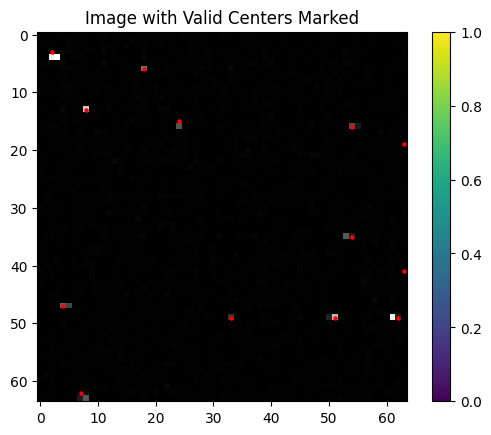

(<matplotlib.image.AxesImage at 0x7f527857d950>, 2806)

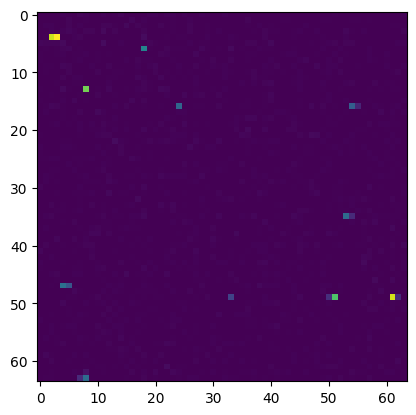

In [11]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l]),l
# plt.grid(True),l

In [56]:
np.max(sorted_centers)

NameError: name 'sorted_centers' is not defined

(<matplotlib.image.AxesImage at 0x7f527840d950>, 2761)

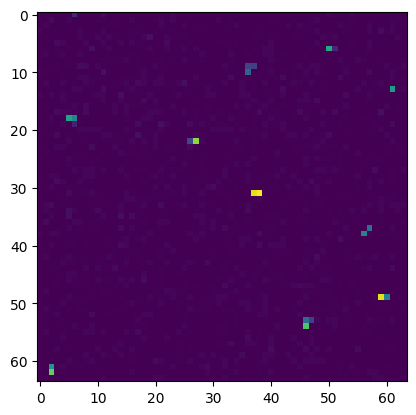

In [10]:
plt.imshow(images[l]),l

In [9]:
t = np.random.randint(0,len(centers))
centers[t]

array([[ 1., 38., 19.],
       [ 1., 45., 33.],
       [ 1., 32., 28.],
       [ 1., 29., 43.],
       [ 1., 40., 63.],
       [ 1., 15., 10.],
       [ 1., 39., 52.],
       [ 1., 48., 11.],
       [ 1., 18., 18.],
       [ 1., 62., 18.],
       [ 1.,  3., 20.],
       [ 1., 16., 41.],
       [ 1., 30., 25.]], dtype=float32)

In [12]:

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))


In [13]:
np.min(train_images), np.max(train_images), np.min(train_midpoints), np.max(train_midpoints)

(0.0, 1.0, 0.0, 1.0)

In [14]:
np.max(centers)

63.0

In [15]:

batch_size = 400
train_dataset = train_dataset.shuffle(buffer_size=8000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=8000).batch(batch_size)

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (9600, 64, 64), Train Midpoints: (9600, 1, 13, 2)
Validation Images: (2400, 64, 64), Validation Midpoints: (2400, 1, 13, 2)


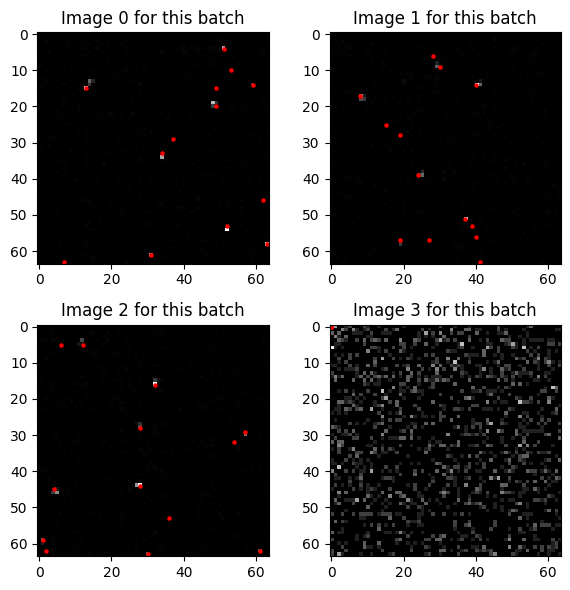

In [16]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [17]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, verbose=1, mode='min', min_lr=3e-5
)


In [19]:

# dynamic_exponent_callback = DynamicExponentCallback(2, 1, 400)


with strategy.scope():
    # Instantiate the model builder
    # model_builder = ModelBuilder(weights_path= "/home/da886/Analysis/30KFixed_13_SparsespotsrandomSPOTS.keras")
    model_builder = ModelBuilder()

    # Build the model
    model_builder.build_model()

    # Display the model architecture
    model_builder.model.summary()

    # Compile the model using the custom loss function
    # model_builder.compile_model(loss_function=dynamic_exponent_callback.custom_loss(2))
    model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError()) 
    
    # model_builder.compile_model(loss_function=custom_loss(3))e




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints (Dense)             │ (None, 26)             │        26,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints_reshape (Reshape)   │ (None, 1, 13, 2)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,348,762 (39.48 MB)

 Trainable params: 10,348,250 (39.48 MB)

 Non-trainable params: 512 (2.00 KB)

In [20]:

# Train the model with the custom callback
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=1800,
    callbacks_list=[lr_scheduler]
)


Epoch 1/1800


2024-10-11 18:33:13.018081: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-11 18:33:13.021443: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-11 18:33:13.050643: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1728671593.097917  813258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671593.099891  813290 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671593.109830  813267 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671593.163070  813290 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671593.163161  813267 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671593.163180  813258 gpu_timer.c

 4/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 11.5272

W0000 00:00:1728671602.222210  813267 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671602.225416  813267 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 6.5500

2024-10-11 18:33:23.387849: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-11 18:33:23.388009: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-10-11 18:33:23.388109: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
W0000 00:00:1728671603.987760  813264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671603.988273  813264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671603.988863  813264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be re

24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - loss: 6.4152 - val_loss: 7.6049 - learning_rate: 0.0100
Epoch 2/1800


W0000 00:00:1728671608.210240  813288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671608.210644  813293 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671608.211123  813288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671608.212615  813293 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671608.212935  813288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671608.214789  813288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671608.216444  813293 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671608.217562  813288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728671608.219100  813293 gp

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2598

2024-10-11 18:33:30.005281: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.2581 - val_loss: 0.3621 - learning_rate: 0.0100
Epoch 3/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - loss: 0.1340 - val_loss: 0.2373 - learning_rate: 0.0100
Epoch 4/1800


2024-10-11 18:33:34.279822: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.1138 - val_loss: 0.1994 - learning_rate: 0.0100
Epoch 5/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: 0.0976 - val_loss: 0.2528 - learning_rate: 0.0100
Epoch 6/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0913

2024-10-11 18:33:41.167263: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0915 - val_loss: 0.1390 - learning_rate: 0.0100
Epoch 7/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 0.0908 - val_loss: 0.1193 - learning_rate: 0.0100
Epoch 8/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0911 - val_loss: 0.0917 - learning_rate: 0.0100
Epoch 9/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - loss: 0.0886 - val_loss: 0.0899 - learning_rate: 0.0100
Epoch 10/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0873 - val_loss: 0.0893 - learning_rate: 0.0100
Epoch 11/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.0843 - val_loss: 0.0868 - learning_rate: 0.0100
Epoch 12/1800


2024-10-11 18:33:56.021677: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0809 - val_loss: 0.0807 - learning_rate: 0.0100
Epoch 13/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0766 - val_loss: 0.0875 - learning_rate: 0.0100
Epoch 14/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - loss: 0.0749 - val_loss: 0.0957 - learning_rate: 0.0100
Epoch 15/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0706 - val_loss: 0.0912 - learning_rate: 0.0100
Epoch 16/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - loss: 0.0710 - val_loss: 0.0853 - learning_rate: 0.0100
Epoch 17/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0668 - val_loss: 0.0712 - learning_rate: 0.0100
Epoch 18/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - loss: 0.0629 - val_loss: 0.1002 - learning_rate: 0.0100
Epoch 19/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0653 - val_loss: 0.2275 - learning_rate: 0.0100
Epoch 20/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - loss: 0.0567 - val_loss: 0.1298 - learning_rate: 0.0100
Ep

2024-10-11 18:34:26.004300: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 0.0584 - val_loss: 0.0818 - learning_rate: 0.0100
Epoch 23/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0534 - val_loss: 0.0531 - learning_rate: 0.0100
Epoch 24/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.0507 - val_loss: 0.0644 - learning_rate: 0.0100
Epoch 25/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0551 - val_loss: 0.0539 - learning_rate: 0.0100
Epoch 26/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: 0.0513 - val_loss: 0.0772 - learning_rate: 0.0100
Epoch 27/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0554 - val_loss: 0.0477 - learning_rate: 0.0100
Epoch 28/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: 0.0494 - val_loss: 0.0593 - learning_rate: 0.0100
Epoch 29/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0496 - val_loss: 0.0549 - learning_rate: 0.0100
Epoch 30/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.0511 - val_loss: 0.0458 - learning_rate: 0.0100
E

2024-10-11 18:35:24.362500: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 0.0469 - val_loss: 0.0565 - learning_rate: 0.0100
Epoch 45/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0489
Epoch 45: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0487 - val_loss: 0.0450 - learning_rate: 0.0100
Epoch 46/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.0451 - val_loss: 0.0480 - learning_rate: 0.0090
Epoch 47/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0492 - val_loss: 0.0485 - learning_rate: 0.0090
Epoch 48/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.0457 - val_loss: 0.0488 - learning_rate: 0.0090
Epoch 49/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0424 - val_loss: 0.0396 - learning_rate: 0.0090
Epoch 50/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.0433 - val_loss: 0.0426 - learning_rate: 0.0090
Epoch 51/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0420 - val_loss: 0.0447 - learn

2024-10-11 18:37:23.878609: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0351 - val_loss: 0.0395 - learning_rate: 0.0073
Epoch 87/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 0.0357 - val_loss: 0.0401 - learning_rate: 0.0073
Epoch 88/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0351 - val_loss: 0.0473 - learning_rate: 0.0073
Epoch 89/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0358
Epoch 89: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.0358 - val_loss: 0.0459 - learning_rate: 0.0073
Epoch 90/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0351 - val_loss: 0.0471 - learning_rate: 0.0066
Epoch 91/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.0327 - val_loss: 0.0485 - learning_rate: 0.0066
Epoch 92/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0329 - val_loss: 0.0427 - learning_rate: 0.0066
Epoch 93/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0338 - val_loss: 0.0499 - learni

2024-10-11 18:41:12.171886: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.0126 - val_loss: 0.0545 - learning_rate: 0.0028
Epoch 173/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0120 - val_loss: 0.0515 - learning_rate: 0.0028
Epoch 174/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - loss: 0.0121 - val_loss: 0.0513 - learning_rate: 0.0028
Epoch 175/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0117 - val_loss: 0.0552 - learning_rate: 0.0028
Epoch 176/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 0.0114 - val_loss: 0.0534 - learning_rate: 0.0028
Epoch 177/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0116 - val_loss: 0.0544 - learning_rate: 0.0028
Epoch 178/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - loss: 0.0114 - val_loss: 0.0534 - learning_rate: 0.0028
Epoch 179/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0114
Epoch 179: ReduceLROnPlateau reducing learning rate to 0.0025418657809495927.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0113 - val_loss: 0.056

2024-10-11 18:48:58.839659: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0018 - val_loss: 0.0563 - learning_rate: 4.7101e-04
Epoch 344/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.0017 - val_loss: 0.0588 - learning_rate: 4.7101e-04
Epoch 345/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0017 - val_loss: 0.0567 - learning_rate: 4.7101e-04
Epoch 346/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 0.0017 - val_loss: 0.0574 - learning_rate: 4.7101e-04
Epoch 347/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0017 - val_loss: 0.0586 - learning_rate: 4.7101e-04
Epoch 348/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - loss: 0.0016 - val_loss: 0.0593 - learning_rate: 4.7101e-04
Epoch 349/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0017
Epoch 349: ReduceLROnPlateau reducing learning rate to 0.0004239115834934637.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0017 - val_loss: 0.0576 - learning_rate: 4.7101e-04
Epoch 350/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - los

2024-10-11 19:04:24.440103: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - loss: 7.6400e-04 - val_loss: 0.0672 - learning_rate: 3.0000e-05
Epoch 685/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 7.4311e-04 - val_loss: 0.0590 - learning_rate: 3.0000e-05
Epoch 686/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 7.4970e-04 - val_loss: 0.0570 - learning_rate: 3.0000e-05
Epoch 687/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 7.5553e-04 - val_loss: 0.0617 - learning_rate: 3.0000e-05
Epoch 688/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 7.5807e-04 - val_loss: 0.0572 - learning_rate: 3.0000e-05
Epoch 689/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 7.5087e-04 - val_loss: 0.0589 - learning_rate: 3.0000e-05
Epoch 690/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 7.5813e-04 - val_loss: 0.0630 - learning_rate: 3.0000e-05
Epoch 691/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 7.4813e-04 - val_loss: 0.0585 - learning_rate: 3.0000e-05
Epoch 692/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4

2024-10-11 19:35:37.050145: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.3023e-04 - val_loss: 0.0580 - learning_rate: 3.0000e-05
Epoch 1368/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 6.5838e-04 - val_loss: 0.0579 - learning_rate: 3.0000e-05
Epoch 1369/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.1118e-04 - val_loss: 0.0620 - learning_rate: 3.0000e-05
Epoch 1370/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 6.4147e-04 - val_loss: 0.0588 - learning_rate: 3.0000e-05
Epoch 1371/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 6.0521e-04 - val_loss: 0.0578 - learning_rate: 3.0000e-05
Epoch 1372/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 6.0480e-04 - val_loss: 0.0670 - learning_rate: 3.0000e-05
Epoch 1373/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.4362e-04 - val_loss: 0.0569 - learning_rate: 3.0000e-05
Epoch 1374/1800
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 6.2216e-04 - val_loss: 0.0579 - learning_rate: 3.0000e-05
Epoch 1375/1800
24/24 ━━━━━━━━━━━━━━

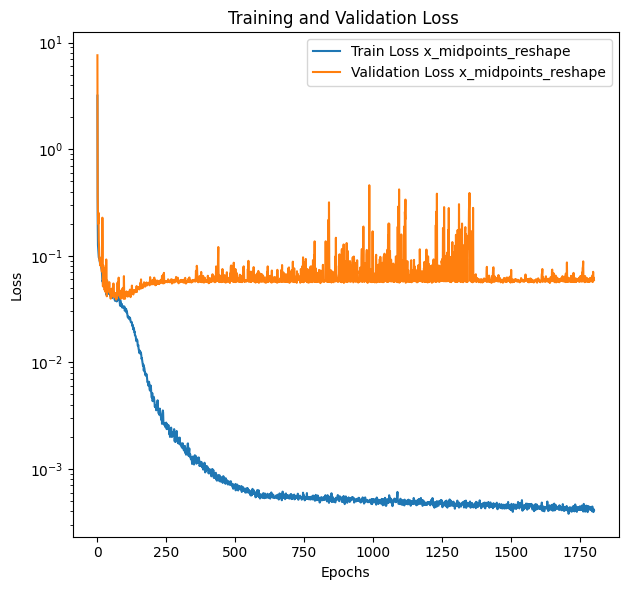

In [21]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [43]:
# model_builder.model.save("/home/da886/Analysis/12KFixed_13_SparsespotsrandomSPOTSoverfit.keras")
# loaded_model = tf.keras.models.load_model(
# "/home/da886/Analysis/30KFixed_13_SparsespotsrandomSPOTS.keras",
# )

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title(title)

    # Plot midpoints directly, only if they are not (0, 0)
    for i, (x, y) in enumerate(midpoints_np):
        if x >= 0 and y >= 0:  # Only plot if the point is not (0, 0)
            plt.scatter(x, y, color='red', s=5)

    plt.show()

# Create the validation dataset
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# val_dataset = val_dataset.batch(800)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)
# # Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# # Loop through each batch in the validation dataset, predict, and collect results
# for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions =model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 64, 64)


W0000 00:00:1728677090.987900  813257 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677090.988805  813224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677090.989864  813289 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677090.990394  813224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677090.990490  813257 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677090.990771  813289 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677090.990922  813224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677090.990943  813257 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677090.991396  813257 gp

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

W0000 00:00:1728677091.424980  813257 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677091.428451  813257 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677091.429977  813257 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677091.433144  813257 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677091.436433  813257 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677091.436781  813257 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677091.437139  813257 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677091.437529  813257 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728677091.437839  813257 gp

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Processing batch 2, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 3, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 4, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 5, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 6, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Processing batch 7, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Processing batch 8, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 9, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 10, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 11, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 12, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [25]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)

In [23]:
all_images.shape,all_pred_midpoints.shape,all_true_midpoints.shape

((9600, 64, 64), (9600, 1, 13, 2), (9600, 1, 13, 2))

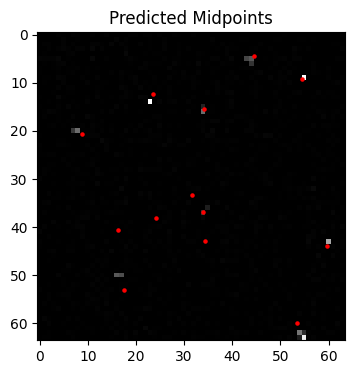

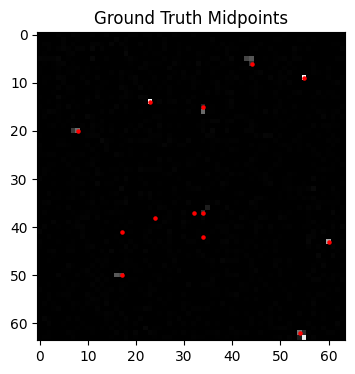

In [29]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * np.max(centers), title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * np.max(centers), title="Ground Truth Midpoints")


In [30]:
np.min(all_pred_midpoints)*np.max(centers),np.max(all_pred_midpoints)*np.max(centers)

(-160.59007, 303.0473)

In [31]:
np.min(all_true_midpoints)*np.max(centers),np.max(all_true_midpoints)*np.max(centers)

(0.0, 63.0)

In [32]:
np.min(train_images), np.max(train_images), np.min(train_midpoints)*np.max(centers), np.max(train_midpoints)*np.max(centers)

(0.0, 1.0, 0.0, 63.0)

In [34]:
all_pred_midpoints[2]*np.max(centers),all_true_midpoints[2]*np.max(centers)

(array([[[37.49769  ,  0.893701 ],
         [ 5.268126 ,  2.3811095],
         [ 6.2055097,  9.41111  ],
         [38.5479   , 14.923272 ],
         [ 1.6805356, 27.386879 ],
         [45.822754 , 30.42933  ],
         [27.461199 , 36.76014  ],
         [39.048737 , 38.981136 ],
         [13.185979 , 48.234604 ],
         [38.724014 , 50.478184 ],
         [ 5.041256 , 56.032772 ],
         [27.951286 , 54.13892  ],
         [28.76817  , 58.81217  ]]], dtype=float32),
 array([[[37.,  1.],
         [ 6.,  3.],
         [ 5., 11.],
         [38., 13.],
         [ 1., 30.],
         [46., 33.],
         [28., 34.],
         [38., 38.],
         [14., 48.],
         [38., 50.],
         [ 5., 57.],
         [28., 57.],
         [29., 59.]]], dtype=float32))

In [35]:
centers

array([[[ 1., 35., 12.],
        [ 1., 63., 52.],
        [ 1., 11., 43.],
        ...,
        [ 1., 10., 33.],
        [ 1., 11., 48.],
        [ 1., 59., 49.]],

       [[ 1.,  5., 24.],
        [ 1., 34., 55.],
        [ 1., 42., 29.],
        ...,
        [ 1.,  2., 55.],
        [ 1., 13., 17.],
        [ 1., 45.,  8.]],

       [[ 1., 38., 36.],
        [ 1., 11., 33.],
        [ 1., 40., 40.],
        ...,
        [ 1., 45.,  5.],
        [ 1.,  8.,  7.],
        [ 1., 55., 37.]],

       ...,

       [[ 1., 50., 18.],
        [ 1., 20., 19.],
        [ 1., 63.,  8.],
        ...,
        [ 1., 32., 44.],
        [ 1., 63., 24.],
        [ 1., 51., 52.]],

       [[ 1.,  6., 33.],
        [ 1., 23., 59.],
        [ 1., 13., 48.],
        ...,
        [ 1., 26., 62.],
        [ 1., 20., 42.],
        [ 1., 53.,  2.]],

       [[ 1., 24., 40.],
        [ 1., 30., 43.],
        [ 1., 38., 55.],
        ...,
        [ 1., 31., 56.],
        [ 1., 21., 50.],
        [ 1., 15.,  6.]]

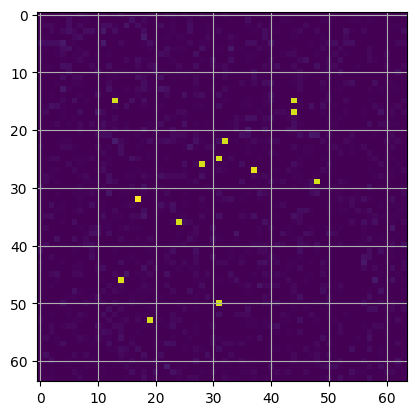

In [32]:
plt.imshow(images[2],)
plt.grid(True)

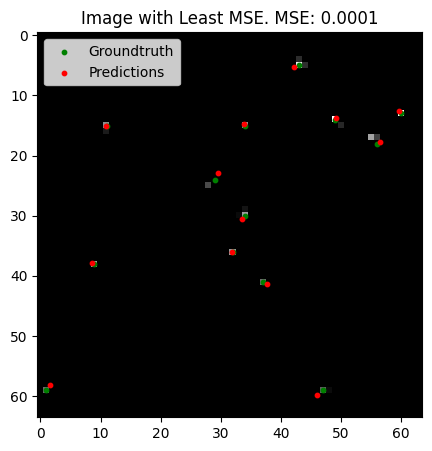

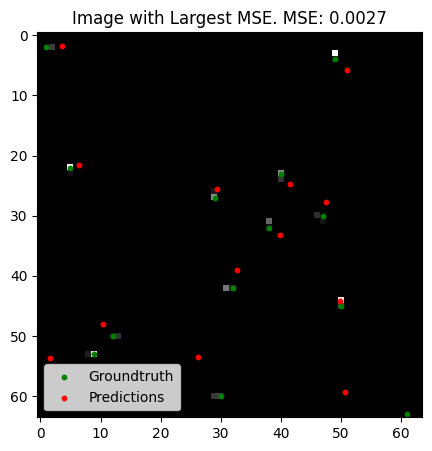

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) **2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')




In [22]:
max_mse_index

5266